In [1]:
# Datagen inspo taken from 
# https://colab.research.google.com/github/reiinakano/invariant-risk-minimization/blob/master/invariant_risk_minimization_colored_mnist.ipynb#scrollTo=sopHPgEhu4Jo

%matplotlib notebook
import os

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision import datasets
import torchvision.datasets.utils as dataset_utils

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics import Accuracy, AUROC
import time
import torch.nn.functional as F

import random

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import minmax_scale

import pickle 
import seaborn as sns

import scipy

SEED = 1234
DEVICE = 'cpu'
np.random.seed(SEED)
torch.manual_seed(SEED)

In [4]:
data_path = './data/'
if not os.path.exists(data_path):
    os.makedirs(data_path)
train_mnist = datasets.mnist.MNIST(data_path, train=True, download=True)
test_mnist = datasets.mnist.MNIST(data_path, train=False, download=True)

In [5]:
# lower = 0
# upper = 1
# mu = 0.5
# sigma = 0.3
# truncnorm = scipy.stats.truncnorm((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma)

In [4]:
# sample = np.array(train_mnist[0][0]).reshape((28,28,1))
# print(sample.shape)
# print(np.max(sample))
# sample = sample / np.max(sample)
# print(np.max(sample))
# print(np.sum(sample))

# sample_3 = np.concatenate([sample,sample,sample], axis=2)
# print(sample_3.shape)
# print(np.sum(sample_3))

(28, 28, 1)
255
1.0
107.94117647058823
(28, 28, 3)
323.82352941176475


In [5]:
# def scale_to_sum(arr, arrsum):
#     return (arrsum / np.sum(arr)) * arr

In [6]:
# # arr_noisy = sample_coloured[:,:,0] + scale_to_sum(noise[:,:,0], np.sum(sample_coloured[:,:,0]))

# noise_scale = 0.9


# sample_coloured = sample_3.copy()
# sample_coloured[:,:,1] *= 0.9
# sample_coloured[:,:,2] *= 0.1
# print(np.sum(sample_coloured[:,:,0]), np.sum(sample_coloured[:,:,1]) + np.sum(sample_coloured[:,:,2]))

# noise = truncnorm.rvs(size=(28,28,3))

# print(np.sum(noise[:,:,0]))

# scaled_noise = scale_to_sum(noise[:,:,0], np.sum(sample_coloured[:,:,0]))

# print(np.sum(scaled_noise))

# sample_coloured[:,:,0] = (1-noise_scale) * sample_coloured[:,:,0] + noise_scale*scale_to_sum(noise[:,:,0], np.sum(sample_coloured[:,:,0]))
# sample_coloured[:,:,1] = (1-noise_scale) * sample_coloured[:,:,1] + noise_scale*scale_to_sum(noise[:,:,1], np.sum(sample_coloured[:,:,1]))
# sample_coloured[:,:,2] = (1-noise_scale) * sample_coloured[:,:,2] + noise_scale*scale_to_sum(noise[:,:,2], np.sum(sample_coloured[:,:,2]))

# print(np.sum(sample_coloured[:,:,0]), np.sum(sample_coloured[:,:,1]), np.sum(sample_coloured[:,:,2]))
# print(np.sum(sample_coloured[:,:,0]), np.sum(sample_coloured[:,:,1]) + np.sum(sample_coloured[:,:,2]))

107.94117647058823 107.94117647058825
381.88470895845114
107.94117647058823
107.94117647058826 97.14705882352942 10.794117647058826
107.94117647058826 107.94117647058825


In [45]:
# test = scale_to_sum(sample_coloured[:,:,1:], np.sum(sample_coloured[:,:,0]))

# print(np.sum(sample_coloured[:,:,1:]), np.sum(sample_coloured[:,:,0]))
# # sample_coloured[:,:,1:].shape

107.94117647058825 107.94117647058826


In [7]:
def rescale_values(image,max_val=1.0,min_val=0.0):
    '''
    image - numpy array
    max_val/min_val - float
    '''
    return (image-image.min())/(image.max()-image.min())*(max_val-min_val)+min_val

# Convert MNIST PIL images to 3 channel NP arrays and return separated data and label arrays
def preprocess_data(train_mnist, test_mnist):
    data = np.zeros((len(train_mnist)+len(test_mnist),28,28,3))
    labels = np.zeros(len(train_mnist)+len(test_mnist))
    
    for i, (img, label) in enumerate(train_mnist):
        arr = rescale_values(np.array(img)).reshape((28,28,1))
        
        im_arr = np.concatenate([np.array(arr),np.array(arr),np.array(arr)], axis=2)
    
        data[i] = im_arr
        labels[i] = label
        
    for i, (img, label) in enumerate(test_mnist):
        arr = rescale_values(np.array(img)).reshape((28,28,1))
        
        im_arr = np.concatenate([arr,arr,arr], axis=2)

        data[len(train_mnist)+i] = im_arr
        labels[len(train_mnist)+i] = label
    
    return data, labels

In [8]:
data, labels = preprocess_data(train_mnist, test_mnist)
print(data.max())
print(data.min())

1.0
0.0


In [9]:
# this number needs to be picked s.t. 50% is divisible by 10 and 9
n_per_class = 3600

sorted_data = np.zeros((n_per_class*10,28,28,3))
sorted_labels = np.zeros((n_per_class*10,))

ind = 0
for i in range(10):
    class_labels = np.where(labels==i)[0][:n_per_class]
    sorted_data[ind:ind+n_per_class] = data[class_labels]
    sorted_labels[ind:ind+n_per_class] = labels[class_labels]
    
    ind += n_per_class

In [10]:
# Shuffled 60/20/20 split
# split 60/40 into train and val+test, then split val and test by half
data_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=SEED)
train_indices, val_indices = list(data_splitter.split(X=sorted_data, y=sorted_labels))[0]

x_train = sorted_data[train_indices]
y_train = sorted_labels[train_indices]
x_val_test = sorted_data[val_indices]
y_val_test = sorted_labels[val_indices]

data_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=SEED)
val_indices, test_indices = list(data_splitter.split(X=x_val_test, y=y_val_test))[0]

x_val = x_val_test[val_indices]
y_val = y_val_test[val_indices]

x_test = x_val_test[test_indices]
y_test = y_val_test[test_indices]

In [11]:
def create_colours(neutral_scalar=1.0):
    blue = 1.0
    green = 0.0
    colours = []
    for i in range(11):
        print((neutral_scalar,np.round(blue,1),np.round(green,1)))
        colours.append((neutral_scalar,np.round(blue,1),np.round(green,1)))
        blue -= 0.1
        green += 0.1
        
    return colours

colours = create_colours()
colours.pop(5)

(1.0, 1.0, 0.0)
(1.0, 0.9, 0.1)
(1.0, 0.8, 0.2)
(1.0, 0.7, 0.3)
(1.0, 0.6, 0.4)
(1.0, 0.5, 0.5)
(1.0, 0.4, 0.6)
(1.0, 0.3, 0.7)
(1.0, 0.2, 0.8)
(1.0, 0.1, 0.9)
(1.0, 0.0, 1.0)


(1.0, 0.5, 0.5)

<IPython.core.display.Javascript object>


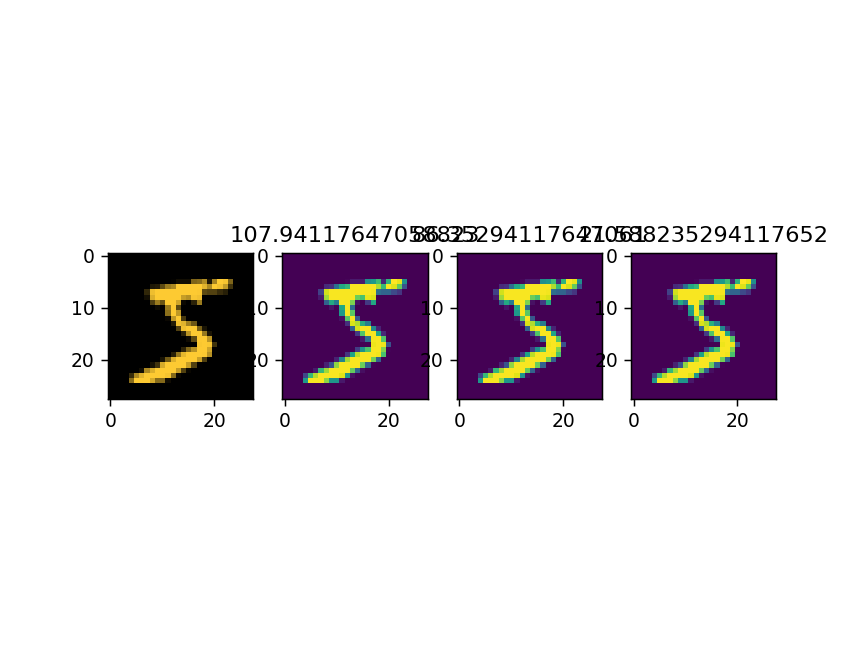

Text(0.5, 1.0, '21.588235294117652')

In [12]:
samp = data[0].copy()
samp[:,:,0] *= 1.0
samp[:,:,1] *= 0.8
samp[:,:,2] *= 0.2


fig, axs = plt.subplots(1,4)
axs[0].imshow(samp)
axs[1].imshow(samp[:,:,0])
axs[1].set_title(np.sum(samp[:,:,0]))

axs[2].imshow(samp[:,:,1])
axs[2].set_title(np.sum(samp[:,:,1]))

axs[3].imshow(samp[:,:,2])
axs[3].set_title(np.sum(samp[:,:,2]))

In [13]:
# create suppressor set where 50% of samples of all classes have colour c6=(0.5,0.5,0.5), 
# and the rest are split evenly 5% for each colour [c0,...,c10]\{c6}

lower = 0
upper = 1
mu = 0.5
sigma = 0.3
truncnorm = scipy.stats.truncnorm((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma)

def scale_to_sum(arr, arrsum):
    return (arrsum / np.sum(np.abs(arr))) * arr

def create_suppressor(data, colours, c6=(1.0,0.5,0.5), noise_scale=0.5):
    num_samples = len(data)
    suppressor_data = np.zeros(data.shape)
    colour_labels = np.zeros((data.shape[0],3))
    
    c6_chunk = data[:int(num_samples/2)]
    c6_chunk[:,:,:,0] *= c6[0]
    c6_chunk[:,:,:,1] *= c6[1]
    c6_chunk[:,:,:,2] *= c6[2]
    
    noise = truncnorm.rvs(size=c6_chunk.shape)
    
#     noise[:,:,:,0] = scale_to_sum(noise[:,:,:,0], np.sum(c6_chunk[:,:,:,0]))

#     noise[:,:,:,1] = scale_to_sum(noise[:,:,:,1], np.sum(noise[:,:,:,0]*0.5))
#     noise[:,:,:,2] = scale_to_sum(noise[:,:,:,2], np.sum(noise[:,:,:,0]*0.5))

    noise[:,:,:,1:] = scale_to_sum(noise[:,:,:,1:], np.sum(noise[:,:,:,0]))
    
    c6_chunk = (1-noise_scale)*c6_chunk + abs(noise_scale*noise)
    colour_labels[:int(num_samples/2)] = np.array([c6]*int(num_samples/2))
    
    suppressor_data[:int(num_samples/2)] =  c6_chunk
    
    for i, data_chunk in enumerate(np.split(data[int(num_samples/2):],10,axis=0)):
        chunk_size = len(data_chunk)

        data_chunk[:,:,:,0] *= colours[i][0]
        data_chunk[:,:,:,1] *= colours[i][1]
        data_chunk[:,:,:,2] *= colours[i][2]
        
        noise = truncnorm.rvs(size=data_chunk.shape)
        
#         noise[:,:,:,0] = scale_to_sum(noise[:,:,:,0], np.sum(data_chunk[:,:,:,0]))

#         noise[:,:,:,1] = scale_to_sum(noise[:,:,:,1], np.sum(noise[:,:,:,0]*0.5))
#         noise[:,:,:,2] = scale_to_sum(noise[:,:,:,2], np.sum(noise[:,:,:,0]*0.5))
        
        noise[:,:,:,1:] = scale_to_sum(noise[:,:,:,1:], np.sum(noise[:,:,:,0]))

        data_chunk = (1-noise_scale)*data_chunk + abs(noise_scale*noise)
        
        suppressor_data[int(num_samples/2)+chunk_size*i:int(num_samples/2)+chunk_size*(i+1)] = data_chunk
        
        colour_labels[int(num_samples/2)+chunk_size*i:int(num_samples/2)+chunk_size*(i+1)] = [colours[i]]*int(data_chunk.shape[0])
    return suppressor_data, colour_labels


# create confounder set where 50% of samples of all classes have colour c6=(0.5,0.5,0.5), 
# 25% have the class' colour and the rest are split evenly for each colour [c0,...,c10]\{c6}
def create_confounder(data, class_colour, colours,confounder_portion=0.25, c6=(1.0,0.5,0.5), noise_scale=0.5):
    num_samples = len(data)
    confounder_data = np.zeros(data.shape)
    colour_labels = np.zeros((data.shape[0],3))

    c6_chunk = data[:int(num_samples/2)]
    c6_chunk[:,:,:,0] *= c6[0]
    c6_chunk[:,:,:,1] *= c6[1]
    c6_chunk[:,:,:,2] *= c6[2]
    
    noise = truncnorm.rvs(size=c6_chunk.shape)
#     noise[:,:,:,0] = scale_to_sum(noise[:,:,:,0], np.sum(c6_chunk[:,:,:,0]))

#     noise[:,:,:,1] = scale_to_sum(noise[:,:,:,1], np.sum(noise[:,:,:,0]*0.5))
#     noise[:,:,:,2] = scale_to_sum(noise[:,:,:,2], np.sum(noise[:,:,:,0]*0.5))

    noise[:,:,:,1:] = scale_to_sum(noise[:,:,:,1:], np.sum(noise[:,:,:,0]))
    
    c6_chunk = (1-noise_scale)*c6_chunk + abs(noise_scale*noise)

    colour_labels[:int(num_samples/2)] = np.array([c6]*int(num_samples/2))
    confounder_data[:int(num_samples/2)] = c6_chunk
    
    n_confounded = int(num_samples/2)+int(num_samples*confounder_portion) 
    
    confounder_data[int(num_samples/2):n_confounded] = data[int(num_samples/2):n_confounded]

    confounder_data[int(num_samples/2):n_confounded][:,:,:,0] *= class_colour[0]
    confounder_data[int(num_samples/2):n_confounded][:,:,:,1] *= class_colour[1]
    confounder_data[int(num_samples/2):n_confounded][:,:,:,2] *= class_colour[2]
    
    noise = truncnorm.rvs(size=confounder_data[int(num_samples/2):n_confounded].shape)
#     noise[:,:,:,0] = scale_to_sum(noise[:,:,:,0], np.sum(confounder_data[int(num_samples/2):n_confounded][:,:,:,0]))
    
#     noise[:,:,:,1] = scale_to_sum(noise[:,:,:,1], np.sum(noise[:,:,:,0]*0.5))
#     noise[:,:,:,2] = scale_to_sum(noise[:,:,:,2], np.sum(noise[:,:,:,0]*0.5))
    
    noise[:,:,:,1:] = scale_to_sum(noise[:,:,:,1:], np.sum(noise[:,:,:,0]))
    
    confounder_data[int(num_samples/2):n_confounded] = (1-noise_scale)*confounder_data[int(num_samples/2):n_confounded] + abs(noise_scale*noise)
    
    colour_labels[int(num_samples/2):n_confounded] = np.array([class_colour]*(n_confounded - int(num_samples/2)))
    
    other_colours = [x for x in colours if x != class_colour] 
    
    for i, data_chunk in enumerate(np.split(data[n_confounded:],9,axis=0)):
        chunk_size = len(data_chunk)

        data_chunk[:,:,:,0] *= other_colours[i][0]
        data_chunk[:,:,:,1] *= other_colours[i][1]
        data_chunk[:,:,:,2] *= other_colours[i][2]
        
        noise = truncnorm.rvs(size=data_chunk.shape)
#         noise[:,:,:,0] = scale_to_sum(noise[:,:,:,0], np.sum(data_chunk[:,:,:,0]))

#         noise[:,:,:,1] = scale_to_sum(noise[:,:,:,1], np.sum(noise[:,:,:,0]*0.5))
#         noise[:,:,:,2] = scale_to_sum(noise[:,:,:,2], np.sum(noise[:,:,:,0]*0.5))

        noise[:,:,:,1:] = scale_to_sum(noise[:,:,:,1:], np.sum(noise[:,:,:,0]))
        
        data_chunk = (1-noise_scale)*data_chunk + abs(noise_scale*noise)
        
        confounder_data[n_confounded+chunk_size*i:n_confounded+chunk_size*(i+1)] = data_chunk
        
        colour_labels[n_confounded+chunk_size*i:n_confounded+chunk_size*(i+1)] = [other_colours[i]]*int(data_chunk.shape[0])
        
    return confounder_data, colour_labels

def create_no_col(data, c6=(1.0,0.5,0.5), noise_scale=0.5):
    no_col_data = np.zeros((data.shape))
    
    c6_chunk = data
    c6_chunk[:,:,:,0] *= c6[0]
    c6_chunk[:,:,:,1] *= c6[1]
    c6_chunk[:,:,:,2] *= c6[2]
    
    noise = truncnorm.rvs(size=data.shape)
    
#     noise[:,:,:,1] = scale_to_sum(noise[:,:,:,1], np.sum(noise[:,:,:,0]*0.5))
#     noise[:,:,:,2] = scale_to_sum(noise[:,:,:,2], np.sum(noise[:,:,:,0]*0.5))

    noise[:,:,:,1:] = scale_to_sum(noise[:,:,:,1:], np.sum(noise[:,:,:,0]))
    
    c6_chunk = (1-noise_scale)*c6_chunk + abs(noise_scale*noise)
    
    return c6_chunk
    
    
#     no_col_train[train_inds] = (1.0-noise_scale)*(x_train[train_inds].copy()) + abs(noise_scale*truncnorm.rvs(size=no_col_train[train_inds].shape))
#     no_col_val[val_inds] = (1.0-noise_scale)*(x_val[val_inds].copy()) + abs(noise_scale*truncnorm.rvs(size=no_col_val[val_inds].shape))
#     no_col_test[test_inds] = (1.0-noise_scale)*(x_test[test_inds].copy()) + abs(noise_scale*truncnorm.rvs(size=no_col_test[test_inds].shape))


In [14]:
def scale_to_bound(row, scale):
    # scale = bound / np.max(np.abs(row))
    return row * scale

noise_scale = 0.75
confounder_portion = 0.4

conf_train = np.zeros(x_train.shape)
conf_val = np.zeros(x_val.shape)
conf_test = np.zeros(x_test.shape)

sup_train = np.zeros(x_train.shape)
sup_val = np.zeros(x_val.shape)
sup_test = np.zeros(x_test.shape)

no_col_train = np.zeros(x_train.shape)
no_col_val = np.zeros(x_val.shape)
no_col_test = np.zeros(x_test.shape)

conf_train_colours = np.zeros((x_train.shape[0], 3))
conf_val_colours = np.zeros((x_val.shape[0], 3))
conf_test_colours = np.zeros((x_test.shape[0], 3))

sup_train_colours = np.zeros((x_train.shape[0], 3))
sup_val_colours = np.zeros((x_val.shape[0], 3))
sup_test_colours = np.zeros((x_test.shape[0], 3))

train_ind = 0
val_ind = 0

for i in range(10):
    train_inds = np.where(y_train==i)[0]
    val_inds = np.where(y_val==i)[0]
    test_inds = np.where(y_test==i)[0]  

    conf_train[train_inds], conf_train_colours[train_inds] = create_confounder(x_train[train_inds].copy(), colours[i], colours, confounder_portion=confounder_portion, noise_scale=noise_scale)
    conf_val[val_inds], conf_val_colours[val_inds] = create_confounder(x_val[val_inds].copy(), colours[i], colours, confounder_portion=confounder_portion, noise_scale=noise_scale)
    conf_test[test_inds], conf_test_colours[test_inds] = create_confounder(x_test[test_inds].copy(), colours[i], colours, confounder_portion=confounder_portion, noise_scale=noise_scale)
    
    sup_train[train_inds], sup_train_colours[train_inds] = create_suppressor(x_train[train_inds].copy(), colours, noise_scale=noise_scale)
    sup_val[val_inds], sup_val_colours[val_inds] = create_suppressor(x_val[val_inds].copy(), colours, noise_scale=noise_scale)
    sup_test[test_inds], sup_test_colours[test_inds] = create_suppressor(x_test[test_inds].copy(), colours, noise_scale=noise_scale)  

    no_col_train[train_inds] = create_no_col(x_train[train_inds].copy(), noise_scale=noise_scale)
    no_col_val[val_inds] = create_no_col(x_val[val_inds].copy(), noise_scale=noise_scale)
    no_col_test[test_inds] = create_no_col(x_test[test_inds].copy(), noise_scale=noise_scale)

#     no_col_train[train_inds] = (1.0-noise_scale)*(x_train[train_inds].copy()) + abs(noise_scale*truncnorm.rvs(size=no_col_train[train_inds].shape))
#     no_col_val[val_inds] = (1.0-noise_scale)*(x_val[val_inds].copy()) + abs(noise_scale*truncnorm.rvs(size=no_col_val[val_inds].shape))
#     no_col_test[test_inds] = (1.0-noise_scale)*(x_test[test_inds].copy()) + abs(noise_scale*truncnorm.rvs(size=no_col_test[test_inds].shape))


scale = 1 / np.max(np.abs(np.vstack([conf_train, conf_val, conf_test])))

conf_train = np.apply_along_axis(scale_to_bound, 1, conf_train, scale)
conf_val = np.apply_along_axis(scale_to_bound, 1, conf_val, scale)
conf_test = np.apply_along_axis(scale_to_bound, 1, conf_test, scale)

##############

scale = 1 / np.max(np.abs(np.vstack([sup_train, sup_val, sup_test])))

sup_train = np.apply_along_axis(scale_to_bound, 1, sup_train, scale)
sup_val = np.apply_along_axis(scale_to_bound, 1, sup_val, scale)
sup_test = np.apply_along_axis(scale_to_bound, 1, sup_test, scale)

##############

scale = 1 / np.max(np.abs(np.vstack([no_col_train, no_col_val, no_col_test])))

no_col_train = np.apply_along_axis(scale_to_bound, 1, no_col_train, scale)
no_col_val = np.apply_along_axis(scale_to_bound, 1, no_col_val, scale)
no_col_test = np.apply_along_axis(scale_to_bound, 1, no_col_test, scale)



In [17]:
print(np.sum(conf_train[:,:,:,0]), np.sum(conf_train[:,:,:,1]) + np.sum(conf_train[:,:,:,2]))

6910031.44854736 6910031.448547358


In [18]:
print(np.sum(no_col_train[:,:,:,0]), np.sum(no_col_train[:,:,:,1]) + np.sum(no_col_train[:,:,:,2]))

6908947.732961149 6908947.732961152


In [19]:
def show_class_data(x_conf, x_sup, x_no_col, y, class_ind=0, n_cols=10):
    class_inds = np.where(y==class_ind)[0]
    
    sample = random.sample(list(class_inds), n_cols)
    fig, axs = plt.subplots(3,n_cols, figsize=(10,4))
    
    dataset_labels = ['Confounder', 'Suppressor', 'No\nColour']
    
    for i, dataset in enumerate([x_conf, x_sup, x_no_col]):
        for j in range(n_cols):
            if i == 0:
                axs[i,j].set_title(f'Sample\n{sample[j]}')
            axs[i,j].imshow(dataset[sample[j]])
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])
            
        axs[i,0].set_ylabel(dataset_labels[i])
            
    plt.show()

<IPython.core.display.Javascript object>


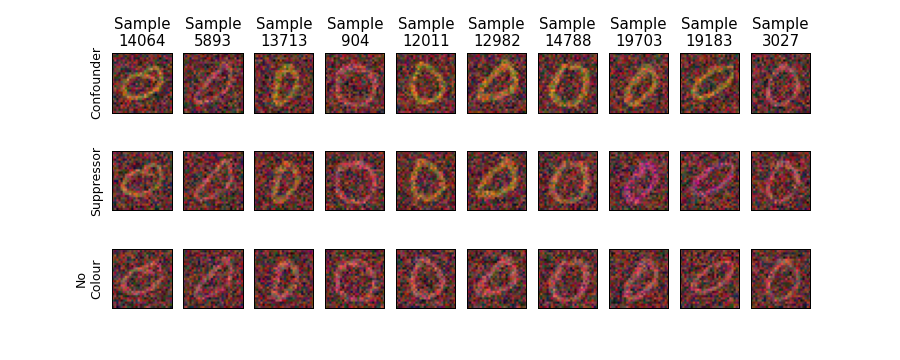

In [20]:
show_class_data(conf_train, sup_train, no_col_train, y_train, class_ind=0, n_cols=10)

In [72]:
import pickle as pkl

conf_save = [(conf_train, y_train, conf_train_colours), (conf_val, y_val, conf_val_colours), (conf_test, y_test, conf_test_colours)]
sup_save = [(sup_train, y_train, sup_train_colours), (sup_val, y_val, sup_val_colours), (sup_test, y_test, sup_test_colours)]
no_col_save = [(no_col_train, y_train), (no_col_val, y_val), (no_col_test, y_test)]


with open('mnist_conf_data.pkl', 'wb') as f:
    pkl.dump(conf_save, f)
    
with open('mnist_sup_data.pkl', 'wb') as f:
    pkl.dump(sup_save, f)
    
with open('mnist_no_col_data.pkl', 'wb') as f:
    pkl.dump(no_col_save, f)

## Model Training
Following the implementation of Anders et. al (2022): https://www.sciencedirect.com/science/article/pii/S1566253521001573
and https://colab.research.google.com/github/reiinakano/invariant-risk-minimization/blob/master/invariant_risk_minimization_colored_mnist.ipynb#scrollTo=9hYJRewnv80x


All models on colored MNIST in Sections 3.2 and 4.1 are trained
using the AdaDelta algorithm with a learning rate of 1.0, which is
multiplied by 0.7 after each epoch, for 10 epochs. The a posteriori ClArC
is trained for 10 epochs on top of the baseline model, which has also
been trained for 10 epochs. The network consists of 2 convolutional
layers, followed by a max-pooling, and finally 2 fully-connected layers.
Dropout is used after the max pooling and after the first fully-connected
layer, with 25 percent and 50 percent dropout probabilities respectively. ReLU activations follow all fully-connected layers except the
final one. The model used for 5.1 is trained with SGD, with a learning
rate of 0.001 for 5 epochs. The architecture, however, is the same as
for the other colored MNIST models.

In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)
        return logits

In [20]:
def train(lr,epochs,train_loader,val_loader,name_model,momentum=0.9,weight_decay=1e-3,num_models=10):
    metric = AUROC(task='multiclass', num_classes=10) 
    softmax = nn.Softmax(dim=1)
    
    training_accuracy = Accuracy(task='multiclass', num_classes=10).to(DEVICE)
    val_accuracy = Accuracy(task='multiclass', num_classes=10).to(DEVICE)

    torch.manual_seed(SEED)

    trained_models = []
    training_logs = []

    for training_ind in range(num_models):
        cnn_conf=Net()
        cnn_conf.to(DEVICE)
        criterion = nn.CrossEntropyLoss()
        
        # Anders et. al uses mainly AdaDelta but also SGD in one section
#         optimizer = optim.SGD(cnn_conf.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
        optimizer = optim.Adadelta(cnn_conf.parameters(), lr=lr, weight_decay=weight_decay)


        loss_list_train=[]
        loss_list_val=[]
        acc_list_train=[]
        acc_list_val=[]
        

        min_loss = 100000000
    #     last_loss = 1000000000

        for epoch in range(epochs):  # loop over the dataset multiple times
            print(f' epoch {epoch+1} in {epochs}')
            t0=time.time()
            epoch_loss = 0.0
            epoch_loss_val= 0.0
            batch_acc=[]
            batch_acc_val=[]

            auroc_train=[]
            auroc_val=[]

            pred_train=[]
            pred_val=[]
            true_labels_train=[]
            true_labels_val=[]

            for i, data in enumerate(train_loader):
                inputs, labels = data

                inputs = inputs.to(DEVICE,dtype=torch.float)
                labels = labels.type(torch.LongTensor)
                labels=labels.to(DEVICE)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = cnn_conf(inputs).squeeze()
                _, predicted = torch.max(outputs.data,1)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()        
                batch_acc.append(training_accuracy(predicted, labels).item())

#                 print(softmax(outputs)[:,1].detach().numpy().shape)
#                 pred_train=np.concatenate((pred_train, softmax(outputs)[:,1].detach().numpy()))
#                 true_labels_train=np.concatenate((true_labels_train, labels.cpu().numpy()))
                
                auroc_train.append(metric(outputs,labels.to(torch.int32)))

            auroc_train = sum(auroc_train)/len(auroc_train)

            for i_v, data_val in enumerate(val_loader):
                inputs_val, labels_val = data_val

                inputs_val = inputs_val.to(DEVICE,dtype=torch.float)
                labels_val = labels_val.type(torch.LongTensor)
                labels_val=labels_val.to(DEVICE)

                outputs_val = cnn_conf(inputs_val).squeeze()
                _, predicted_val = torch.max(outputs_val.data, 1)

                loss_val = criterion(outputs_val, labels_val)

                epoch_loss_val += loss_val.item()        
                batch_acc_val.append(val_accuracy(predicted_val, labels_val).item())

                auroc_val.append(metric(outputs_val,labels_val.to(torch.int32)))

#                 pred_val=np.concatenate((pred_val, softmax(outputs_val)[:,1].cpu().detach().numpy()))
#                 true_labels_val=np.concatenate((true_labels_val, labels_val.cpu().detach().numpy()))
            auroc_val = sum(auroc_val)/len(auroc_val)

            if epoch_loss_val < min_loss:
                min_loss = epoch_loss_val
                save_model = type(cnn_conf)() # get a new instance
                save_model.load_state_dict(cnn_conf.state_dict()) # copy weights and stuff

                torch.save(save_model.state_dict(), f'{str(name_model)}_{training_ind}.pt')

#             auroc_val=metric(torch.tensor(pred_val),torch.tensor(true_labels_val).to(torch.int32))

            epoch_acc=sum(batch_acc)/len(batch_acc)
            epoch_acc_val=sum(batch_acc_val)/len(batch_acc_val)

            print(f'epoch train loss: {epoch_loss} | epoch train acc {epoch_acc} | AUROC: {auroc_train}')
            print(f'epoch val loss: {epoch_loss_val} | epoch val acc {epoch_acc_val} | AUROC: {auroc_val}')
            print(f'time elapsed: {round(time.time()-t0,2)} s')

            loss_list_train.append(epoch_loss)
            loss_list_val.append(epoch_loss_val)
            acc_list_train.append(epoch_acc)
            acc_list_val.append(epoch_acc_val)

            epoch_loss = 0.0
            epoch_loss_val=0.0

        print('Finished Training')
        print()
        print('\t \t *******************')
        print()
        
        torch.save(save_model.state_dict(), f'{str(name_model)}_{training_ind}.pt')

        trained_models.append(save_model)
        training_logs.append([acc_list_train, loss_list_train, acc_list_val, loss_list_val])
#     plt.plot(loss_list_train)
#     plt.plot(loss_list_val)
#     plt.plot([i*100 for i in acc_list_train])
#     plt.plot([i*100 for i in acc_list_va])
    return trained_models, [acc_list_train, loss_list_train, acc_list_val, loss_list_val]

In [21]:
train_loader = DataLoader(TensorDataset(torch.tensor(conf_train.transpose(0,3,1,2)), torch.tensor(y_train)), batch_size=1000, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.tensor(conf_val.transpose(0,3,1,2)), torch.tensor(y_val)), batch_size=1000, shuffle=True)

In [22]:
lr = 0.005
epochs = 100
num_models=1

In [23]:
train(lr,epochs,train_loader,val_loader,'mnist_conf',momentum=0.9,weight_decay=1e-3,num_models=num_models)

 epoch 1 in 100


KeyboardInterrupt: 

In [ ]:
train_loader = DataLoader(TensorDataset(torch.tensor(sup_train.transpose(0,3,1,2)), torch.tensor(y_train)), batch_size=1000, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.tensor(sup_val.transpose(0,3,1,2)), torch.tensor(y_val)), batch_size=1000, shuffle=True)

train(lr,epochs,train_loader,val_loader,'mnist_sup',momentum=0.9,weight_decay=1e-3,num_models=num_models)

In [ ]:
train_loader = DataLoader(TensorDataset(torch.tensor(no_col_train.transpose(0,3,1,2)), torch.tensor(y_train)), batch_size=1000, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.tensor(no_col_val.transpose(0,3,1,2)), torch.tensor(y_val)), batch_size=1000, shuffle=True)

train(lr,epochs,train_loader,val_loader,'mnist_no_col',momentum=0.9,weight_decay=1e-3,num_models=num_models)

In [ ]:
def load_trained(path, device='cpu'):
    model = Net()
    model.load_state_dict(torch.load(path,map_location=device))
    return model

def print_AUC(loader, model_ind=0, device='cpu'):

    cnn_conf=load_trained(f'./mnist_conf_{model_ind}.pt').to(device)
    cnn_sup=load_trained(f'./mnist_sup_{model_ind}.pt').to(device)
    cnn_no=load_trained(f'./mnist_no_col_{model_ind}.pt').to(device)
    
    #models -> cnn_no; cnn_sup; cnn_conf

    softmax = nn.Softmax(dim=1)
    metric = AUROC(num_classes=10, task='multiclass')

    model_conf_test_conf_pred=np.array([])
    model_sup_test_conf_pred=np.array([])
    model_no_test_conf_pred=np.array([])
    true_labels=np.array([])
    
    model_conf_auroc_test = []
    model_sup_auroc_test = []
    model_no_col_auroc_test = []

    for i_v, data_val in enumerate(loader):
        inputs_val, labels_val = data_val
        inputs_val = inputs_val.to(DEVICE,dtype=torch.float)
        labels_val = labels_val.type(torch.LongTensor)
        labels_val=labels_val.to(DEVICE)

        outputs_conf = cnn_conf(inputs_val).squeeze()
        outputs_sup = cnn_sup(inputs_val).squeeze()
        outputs_no = cnn_no(inputs_val).squeeze()

        out_pred_conf=softmax(outputs_conf)
        out_pred_sup=softmax(outputs_sup)
        out_pred_no=softmax(outputs_no)

#         model_conf_test_conf_pred=np.concatenate((model_conf_test_conf_pred, out_pred_conf[:,1].cpu().detach().numpy()))
#         model_sup_test_conf_pred=np.concatenate((model_sup_test_conf_pred, out_pred_sup[:,1].cpu().detach().numpy()))
#         model_no_test_conf_pred=np.concatenate((model_no_test_conf_pred, out_pred_no[:,1].cpu().detach().numpy()))

#         print(labels_val.shape)
#         print(model_conf_test_conf_pred)

        model_conf_auroc_test.append(metric(out_pred_conf, labels_val))
        model_sup_auroc_test.append(metric(out_pred_sup, labels_val))
        model_no_col_auroc_test.append(metric(out_pred_no, labels_val))
        
#         true_labels=np.concatenate((true_labels, labels_val.cpu().numpy()))

    print('model: confounder', sum(model_conf_auroc_test)/len(model_conf_auroc_test))
    print('model: suppressor',sum(model_sup_auroc_test)/len(model_sup_auroc_test))
    print('model: no colour',sum(model_no_col_auroc_test)/len(model_no_col_auroc_test))
    print()

    l=[sum(model_conf_auroc_test)/len(model_conf_auroc_test),
       sum(model_sup_auroc_test)/len(model_sup_auroc_test),
       sum(model_no_col_auroc_test)/len(model_no_col_auroc_test)]
    return l


In [ ]:
import pickle as pkl
with open('mnist_conf_data.pkl', 'rb') as f:
    conf_data = pkl.load(f)
    
with open('mnist_sup_data.pkl', 'rb') as f:
    sup_data = pkl.load(f)
    
with open('mnist_no_col_data.pkl', 'rb') as f:
    no_col_data = pkl.load(f)

batch_size = 64

confounder_test_loader = DataLoader(TensorDataset(torch.tensor(conf_data[2][0].transpose(0,3,1,2)), torch.tensor(conf_data[2][1])),batch_size=batch_size, shuffle=False)
suppressor_test_loader = DataLoader(TensorDataset(torch.tensor(sup_data[2][0].transpose(0,3,1,2)), torch.tensor(sup_data[2][1])),batch_size=batch_size, shuffle=False)
no_col_test_loader = DataLoader(TensorDataset(torch.tensor(no_col_data[2][0].transpose(0,3,1,2)), torch.tensor(no_col_data[2][1])),batch_size=batch_size, shuffle=False)


In [ ]:
batch_size=64
# confounder_test_loader = DataLoader(TensorDataset(torch.tensor(conf_test.transpose(0,3,1,2)), torch.tensor(y_test)),batch_size=batch_size, shuffle=False)
# supressor_test_loader = DataLoader(TensorDataset(torch.tensor(sup_test.transpose(0,3,1,2)), torch.tensor(y_test)),batch_size=batch_size, shuffle=False)
# no_col_test_loader = DataLoader(TensorDataset(torch.tensor(no_col_test.transpose(0,3,1,2)), torch.tensor(y_test)),batch_size=batch_size, shuffle=False)

confounder_data_results = []
suppressor_data_results = []
no_col_data_results = []

for i in range(1):
    print(f'MODEL {i}')
    print('confounder data:')
    confounder_data_results.append(print_AUC(confounder_test_loader, i))
    print()
    print('suppressor data:')
    suppressor_data_results.append(print_AUC(suppressor_test_loader, i))
    print()
    print('no colour data:')
    no_col_data_results.append(print_AUC(no_col_test_loader, i))
    print()

In [ ]:
# current problem
# scaling channel noise by sum of that channel will colour background in accordance with pattern colour
# alternative: scale channel noise according to another factor, i.e. sum(channel_0) = 2*sum(channel_1 or _2)
# key aim: keep total mass in red = green + blue
# another problem: we have the c6_chunk = (1.0, 1.0, 1.0) where r = g + b; should we just make this 1.0, 0.5, 0.5? it's 